<h2 align="center" style="color:blue">Data Cleaning & Exploratory Data Analysis</h2>

**Import Necessary Libraries**

In [1]:
# Import necessary libraries
from imports import *

## Data Preparation and Exploration

In [2]:
# Import the dataset and display the first few rows

df = pd.read_excel("../data/raw/premiums.xlsx")

print("Number of rows and columns: ", df.shape)

print("First few rows of the dataset:")
df.head(3)

Number of rows and columns:  (50000, 13)
First few rows of the dataset:


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164


In [3]:
# Clean column names for consistency (replace spaces, lowercase all)

df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


## Handling Missing Values

In [4]:
# Check for any missing values in the dataset and handle them appropriately
print("Missing values in the dataset:")
print(df.isna().sum())

Missing values in the dataset:
age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64


Only 26 records contained missing data (≈0.05% of the total 50,000 rows), primarily in `smoking_status`, `employment_status`, and `income_level`.  
Given the minimal proportion and the absence of a clear pattern, these rows were safely dropped to simplify analysis.

In [5]:
# Drop rows with missing values
df.dropna(inplace=True)

In [6]:
print("Missing values in the dataset:")
print(df.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64


## Checking for Duplicate Records

In [7]:
# Check for any duplicate values in the dataset and handle them appropriately
print("Duplicate values in the dataset:")
print(df.duplicated().sum())

Duplicate values in the dataset:
0


No duplicate rows were found in the dataset.  
If any duplicates had been detected, they would have been removed using `df.drop_duplicates(inplace=True)` to ensure data integrity and avoid double-counting during analysis.

In [8]:
# if duplicate values are found:
df.drop_duplicates(inplace=True)
print("Duplicate values in the dataset:")
print(df.duplicated().sum())

Duplicate values in the dataset:
0


## Summary Statistics of Numerical Features
The table below provides descriptive statistics for all numerical columns, including count, mean, standard deviation, minimum, quartiles, and maximum values.  
This helps identify potential outliers, data entry errors, and the overall distribution of numeric variables.

In [9]:
# Generate quick summary statistics for all numeric columns
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


### Identifying Outliers and Data Anomalies
The summary statistics reveal some irregular values that likely represent data entry errors or outliers:
- **Age:** Maximum value of 356 years — unrealistic and should be investigated or removed.
- **Number of Dependants:** Minimum value of -3 — negative dependants are invalid.
- **Income (₹ Lakhs):** Maximum value of 930 — far above reasonable income levels.

These anomalies will be further analyzed and handled appropriately to maintain data integrity before modeling.

### Investigating Invalid Values in 'number_of_dependants'

In [10]:
# Check for invalid dependant counts (negative values)
print(df[df.number_of_dependants<0]['number_of_dependants'].unique())
print(df[df.number_of_dependants<0].shape)

[-3 -1]
(72, 13)


A total of **72 records** contain negative values for `number_of_dependants` (-1 or -3), which are logically invalid.  
These likely stem from data entry or encoding errors. Since dependants cannot be negative, these rows will be handled appropriately, either corrected or removed from the dataset to maintain data quality.

In [11]:
# Correct negative dependant counts by taking absolute values
df['number_of_dependants'] = abs(df['number_of_dependants'])

# Verifying the updated distribution
df['number_of_dependants'].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

#### Correcting Negative Values in `number_of_dependants`
The 72 records with negative dependant counts (-1 and -3) were corrected by converting the values to their absolute equivalents.  
This approach preserves the data while logically aligning with the assumption that the magnitude represents the correct number of dependants (e.g., -3 → 3).  
After correction, the distribution of dependants appears valid (ranging from 0 to 5).

### Outlier Detection

In [12]:
# Extract all numeric columns (integers and floats)
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

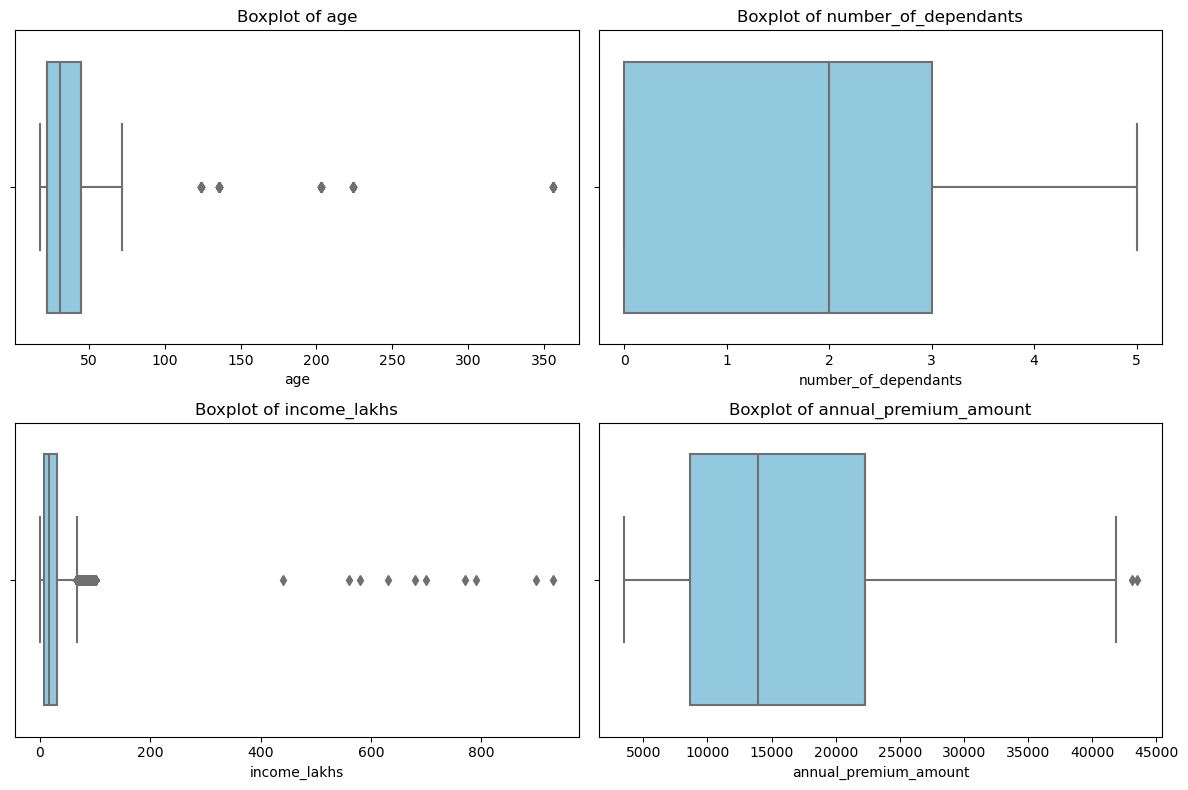

In [13]:
# Visualize outliers for all numeric columns using boxplots
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten so we can loop easily

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.savefig("../outputs/figures/overall/numeric_boxplots_grid.png", dpi=300)
plt.show()

Boxplots were generated for all numeric variables to visually inspect potential outliers.

**Observations:**
- **Age:** A few outliers were observed (e.g., individuals over 100), which may represent data entry errors and will be examined further.  
- **Number of Dependants:** No significant outliers detected.  
- **Income (₹ Lakhs):** Several high-value outliers likely reflect genuine high-income individuals but will be reviewed for extreme deviations.  
- **Annual Premium Amount:** One or two high values observed — acceptable since higher premiums can naturally occur for customers with high income or risk.

Since outliers in some features may hold business relevance, this step will focus on **outlier treatment** rather than removal.

### Outlier Treatment

#### For Age:

In [14]:
# Identify unrealistic age values (>100)
print(df[df.age>100]['age'].shape)
print(df[df.age>100]['age'].unique())

(58,)
[224 124 136 203 356]


A total of **58 records** were identified with unrealistic age values (greater than 100), including extreme entries such as 124, 136, 203, 224, and 356 years.  

Since these are clearly data entry errors and outside the plausible human age range, they were excluded from the analysis.  

To maintain reproducibility and avoid confusion between raw and cleaned data, the filtered dataset has been stored in a **new dataframe (`df1`)**.

In [15]:
# Drop these outliers
# Storing the cleaned data in a new DataFrame for reproducibility
df1 = df[df.age<=100].copy()

# Verify the cleaned data
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


#### For Income:

In [16]:
# Define a function to compute IQR bounds
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check IQR-based bounds
lower, upper = get_iqr_bounds(df1['income_lakhs'])
print(f"IQR bounds: lower={lower}, upper={upper}")

IQR bounds: lower=-29.0, upper=67.0


Since 67 lakhs is not an unreasonable income level in India, we will try to use quantile thresholds to determine a more realistic cap

In [17]:
# using quantile thresholds
for q in [0.9, 0.99, 0.999]:
    print(f"{int(q*100)}th percentile:", df1['income_lakhs'].quantile(q))

90th percentile: 54.0
99th percentile: 96.0
99th percentile: 100.0


In [18]:
# Set an upper threshold of 100L (≈₹1 crore) as the cutoff
quantile_threshold = 100
print("Records above threshold:", df1[df1['income_lakhs'] > quantile_threshold].shape)

Records above threshold: (10, 13)


In [19]:
# Display high-income outlier records (for reference)
high_income_outliers = df1[df1['income_lakhs'] > quantile_threshold]
display(high_income_outliers)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
2635,51,Male,Northwest,Married,4,Obesity,No Smoking,Self-Employed,> 40L,560,High blood pressure,Gold,30692
4220,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636
7775,35,Female,Northeast,Unmarried,0,Overweight,No Smoking,Salaried,> 40L,630,Diabetes,Gold,24010
9021,43,Male,Southeast,Married,3,Obesity,Regular,Salaried,> 40L,900,Diabetes & Thyroid,Gold,30848
10337,37,Female,Southeast,Married,3,Normal,No Smoking,Freelancer,> 40L,930,Diabetes,Silver,15945
10639,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888
11456,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424
15437,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586
35446,59,Male,Northwest,Married,2,Obesity,Occasional,Self-Employed,> 40L,770,Thyroid,Gold,31115
40970,48,Male,Northeast,Married,4,Obesity,No Smoking,Salaried,> 40L,680,No Disease,Gold,28926


In [20]:
# Drop extreme high-income outliers and save to a new dataframe
df2 = df1[df1['income_lakhs'] <= quantile_threshold].copy()

# Verify shape and descriptive stats post-cleaning
print("Cleaned dataset shape:", df2.shape)
df2.describe()

Cleaned dataset shape: (49908, 13)


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


The initial IQR method suggested an upper bound of 67 lakhs, but this threshold is not contextually appropriate for the Indian market — individuals with annual incomes above 67 lakhs are not too extreme.

To better reflect realistic upper income levels, quantile thresholds were tested:
- 90th percentile → 54 lakhs  
- 99th percentile → 96 lakhs  
- 99.9th percentile → 100 lakhs  

A final **upper threshold of 100 lakhs (₹1 crore)** was selected as a reasonable limit for high earners.  
Only **10 records** exceeded this threshold, and these were removed to prevent distortion in income-related analyses.  
The cleaned data was saved into a new dataframe, **`df2`**, to maintain reproducibility and a clear data lineage.


## Distribution Analysis for Numerical Features:

### Univariate Analysis of Numerical Features

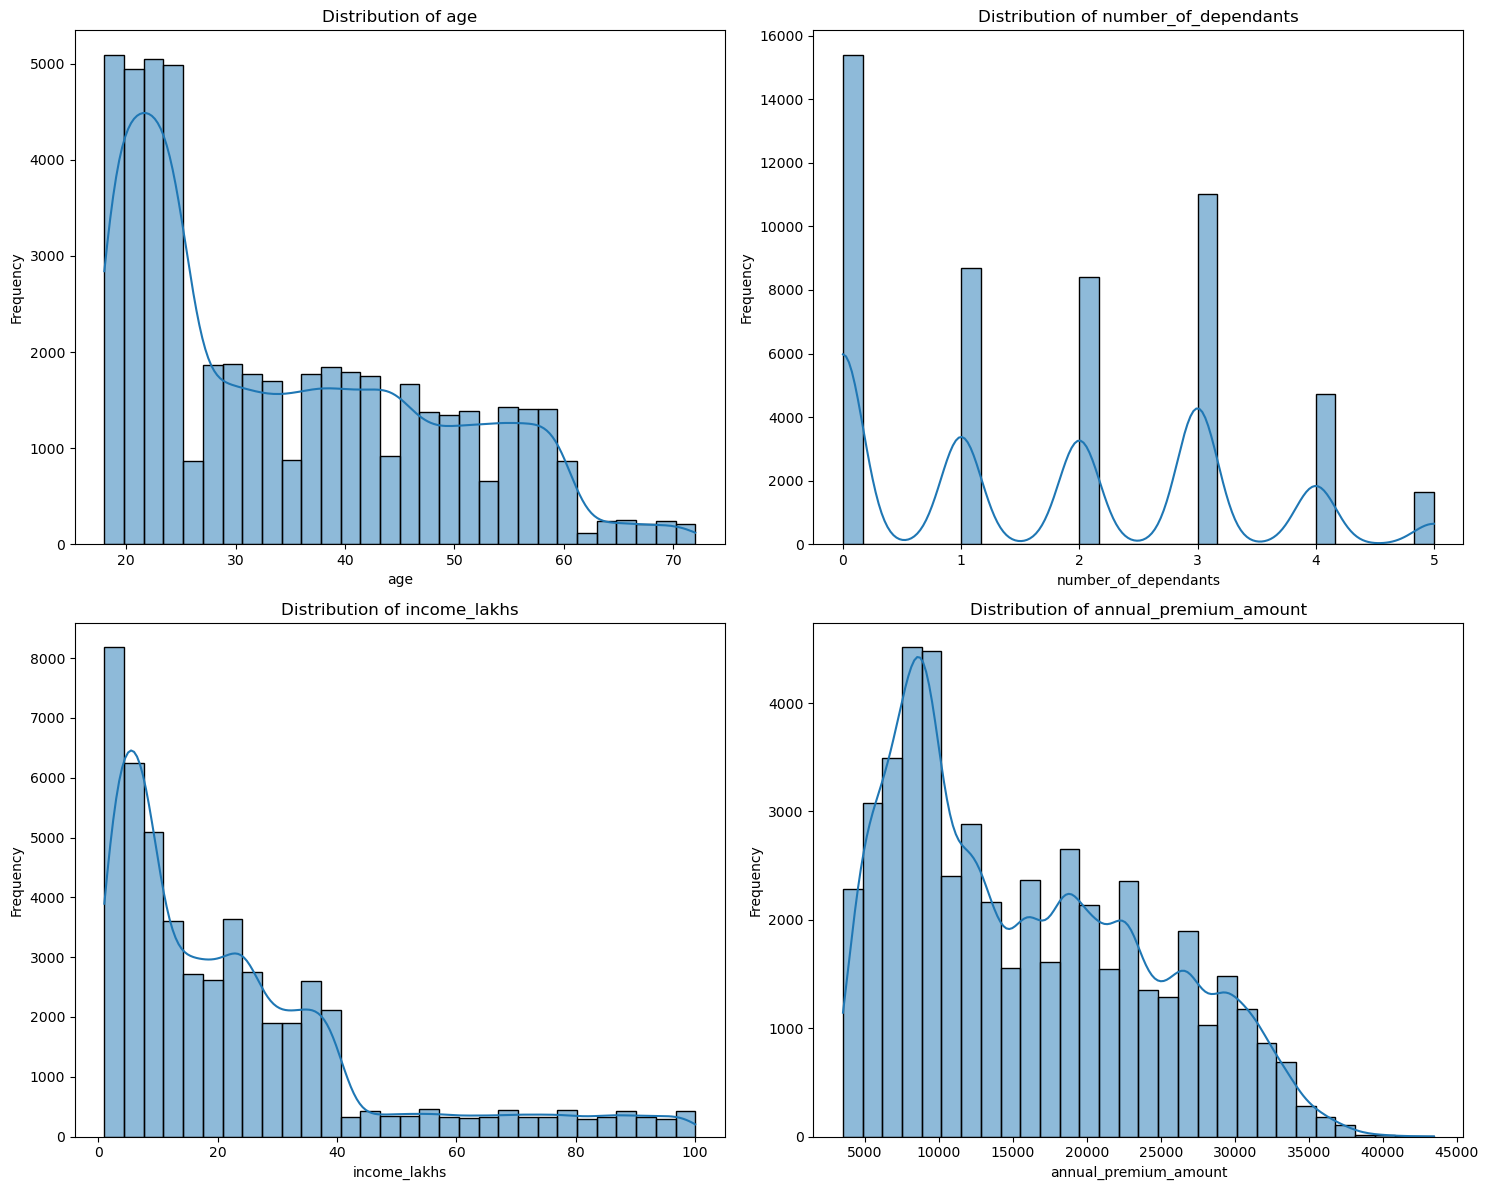

In [21]:
# Plot histograms for all numeric columns to examine data distribution and skewness
plt.figure(figsize=(15,12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df2[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("../outputs/figures/overall/numeric_univariate_distribution_grid.png", dpi=300)
plt.show()

Histograms were plotted for all numerical variables to understand their data distributions and detect skewness.

**Observations:**
- **Age:** Right-skewed — majority of customers are younger, with fewer in higher age ranges.
- **Number of Dependants:** Fairly uniform across categories, except for individuals with **0 dependants**, which is the largest group (~15,000 records).
- **Income (₹ Lakhs):** Right-skewed — most customers earn below 40 lakhs, with fewer high-income individuals.
- **Annual Premium Amount:** Also right-skewed — higher premium values are less frequent, which aligns with business expectations (premium rises with income and coverage).

### Bivariate Analysis of Numerical Features - Relationship Between Numerical Features and Annual Premium Amount

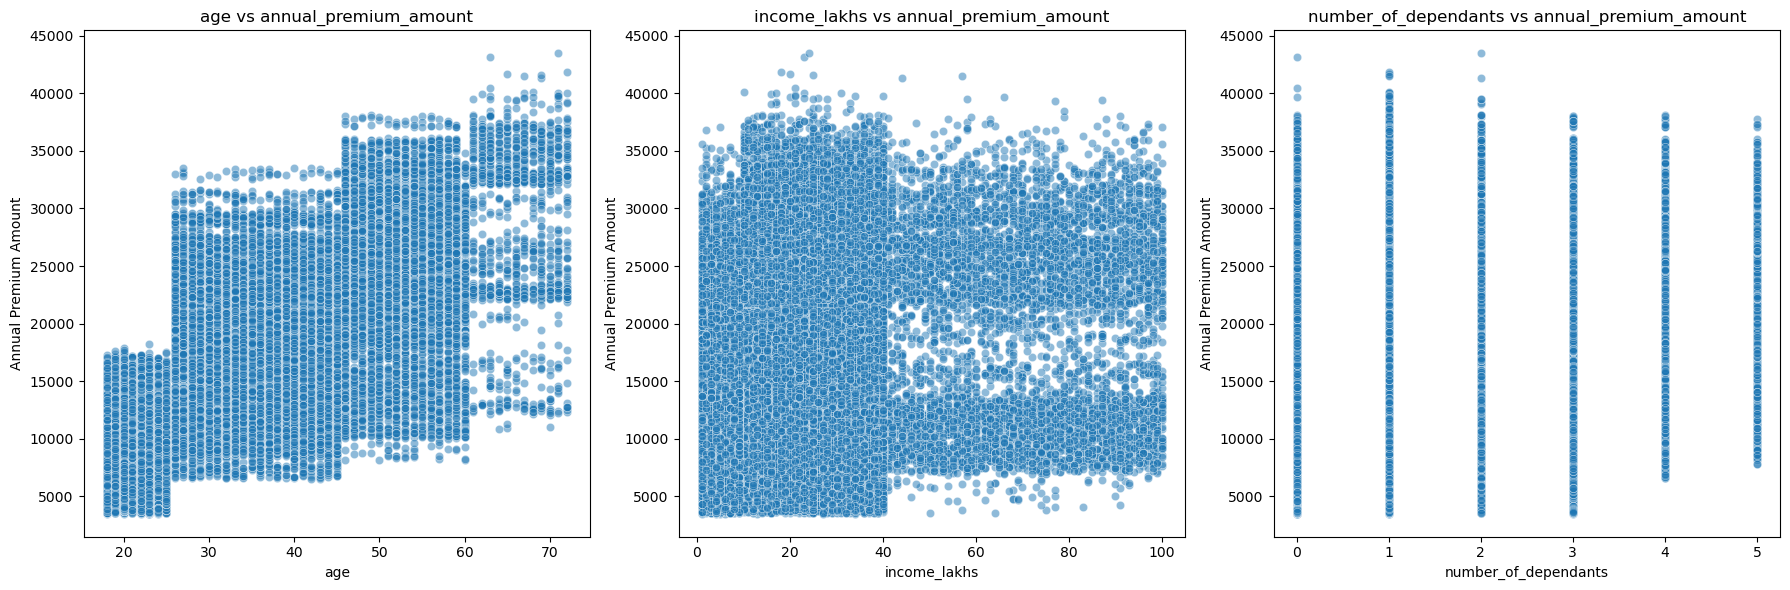

In [22]:
# Scatter plot grid to examine relationships between numeric features and annual premium
plt.figure(figsize=(18, 6))

numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], alpha=0.5)
    plt.title(f'{col} vs annual_premium_amount')
    plt.xlabel(col)
    plt.ylabel('Annual Premium Amount')

plt.tight_layout()
plt.savefig("../outputs/figures/overall/numeric_bivariate_scatter_grid.png", dpi=300)
plt.show()

Scatter plots were created to visualize how key numeric variables (`age`, `income_lakhs`, and `number_of_dependants`) relate to `annual_premium_amount`.

**Observations:**
- **Age vs. Annual Premium:** A mild positive relationship is visible — older individuals tend to pay higher premiums, which aligns with typical risk-based pricing in insurance.
- **Income vs. Annual Premium:** No strong linear relationship observed; higher income does not necessarily lead to higher premiums, possibly due to plan type or coverage preferences influencing premiums more than income.
- **Number of Dependants vs. Annual Premium:** No clear trend — the number of dependants seems to have little to no impact on premium amount.

These findings suggest that **age** may be a relevant factor in premium prediction, while **income** and **dependants** might have weaker direct influence.

## Distribution Analysis for Categorical Features:

In [23]:
# Select categorical columns
categorical_columns = df2.select_dtypes(['object']).columns
# Check unique values in categorical columns to identify inconsistencies
for col in categorical_columns:
    print(col, ":", df2[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [24]:
# Standardizing inconsistent 'smoking_status' entries
# Merge multiple variants representing non-smokers into a single label: 'No Smoking'
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking'
}, inplace=True)

# Verifying that values are now consistent
df2['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Univariate Analysis of Categorical Features

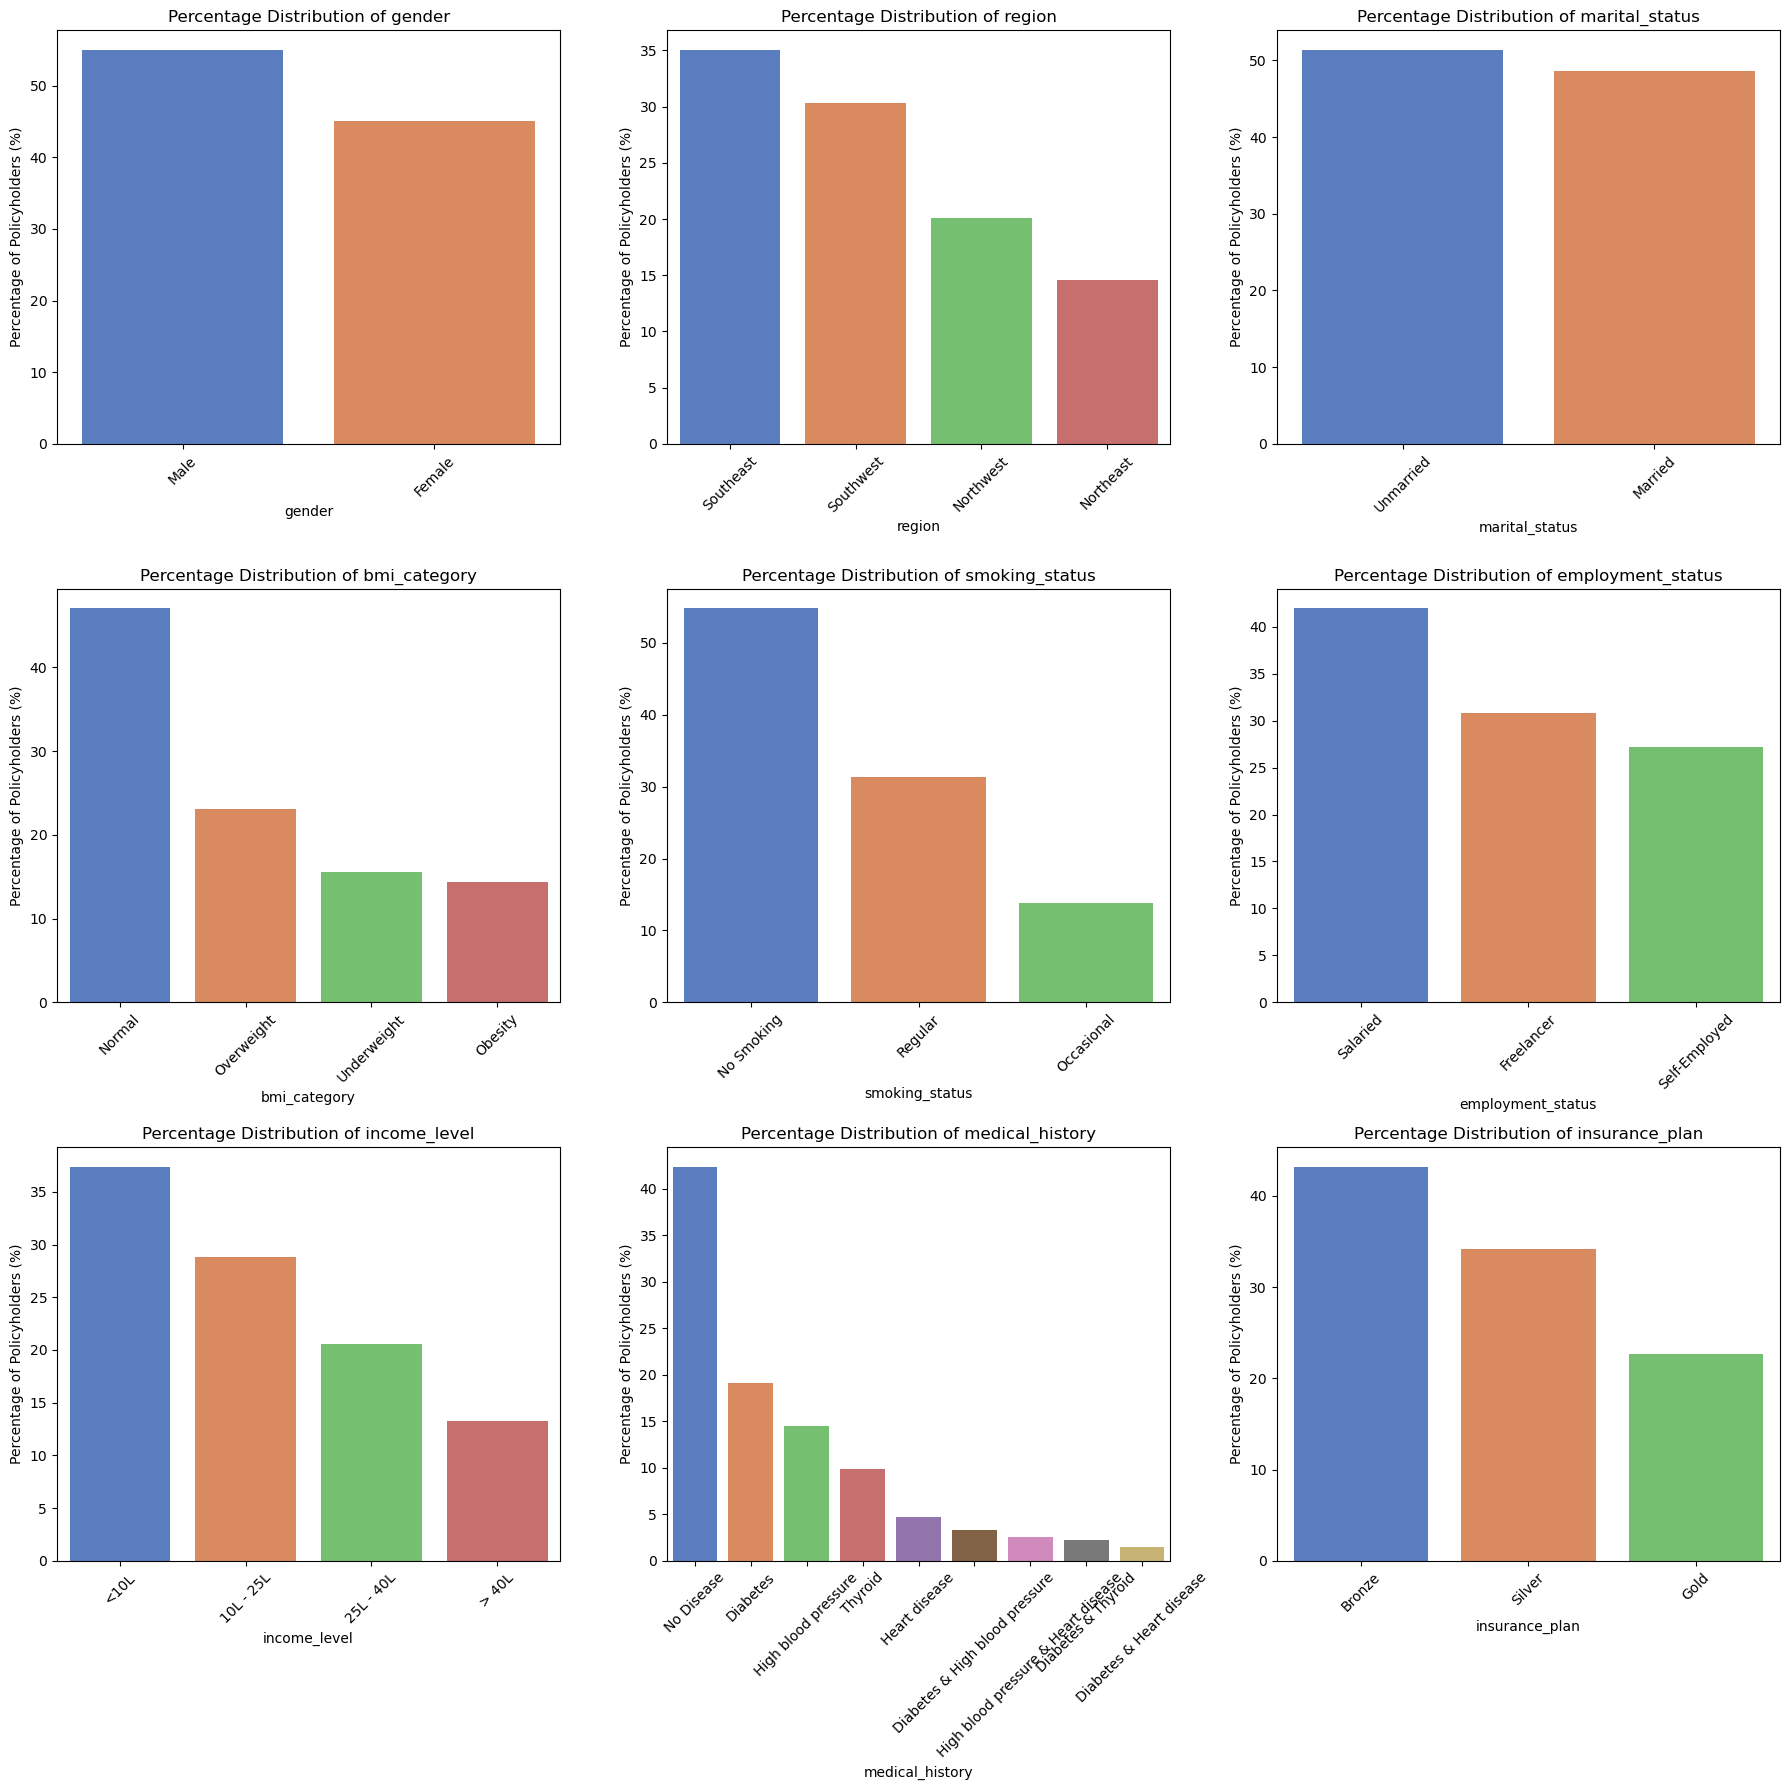

In [25]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    category_counts = df2[col].value_counts(normalize=True) * 100
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i], palette='muted')
    axes[i].set_title(f'Percentage Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.savefig("../outputs/figures/overall/categorical_univariate_distribution_grid.png", dpi=300)
plt.show()

The following section summarizes the distribution of key categorical variables among the 49,000+ policyholders in the dataset.  
Each bar chart represents the percentage share of categories within each feature.

### Key Insights

#### **Gender**
- The dataset shows a slight male majority (~55%), indicating marginally higher participation from men in the insurance segment.

#### **Region**
- The **South** and **East** regions dominate policyholder distribution, while the **West** contributes the least.
- This regional skew could reflect market penetration or distribution focus differences.

#### **Marital Status**
- Policyholders are almost evenly split between **Married** and **Unmarried**, suggesting that marital status alone may not drive premium or plan selection significantly.

#### **BMI Category**
- Nearly half of the insured population falls under the **Normal BMI** range.
- **Overweight** and **Underweight** individuals represent smaller segments, while **Obesity** is least common — implying an overall healthier insured group.

#### **Smoking Status**
- Over **50%** are **Non-smokers**, while **Regular** and **Occasional** smokers form smaller segments.
- This aligns with general trends where non-smokers are more likely to seek health insurance and receive better premium rates.

#### **Employment Status**
- Majority of policyholders are **Salaried**, followed by **Freelancers/Self-employed** individuals.
- Indicates that the customer base leans toward financially stable income groups — a favorable underwriting profile.

#### **Income Level**
- Most policyholders earn **below ₹10 lakhs per annum**, with a gradual drop across higher income bands.
- Reinforces a **cost-sensitive customer segment**, likely preferring affordable coverage options.

#### **Medical History**
- A large portion of the population has **no chronic illness**.
- Among existing conditions, **High Blood Pressure** and **Diabetes** are most common — consistent with national health trends.

#### **Insurance Plan**
- **Bronze plans** are the most subscribed, followed by **Silver** and **Gold**.
- Indicates stronger adoption of entry-level plans, suggesting that affordability is a key decision factor.

### Bivariate Analysis of Categorical Features

### Bivariate Analysis — Income Level vs. Insurance Plan

The relationship between policyholders' **income levels** and their **chosen insurance plans** was analyzed using a grouped bar chart and a frequency heatmap.


insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


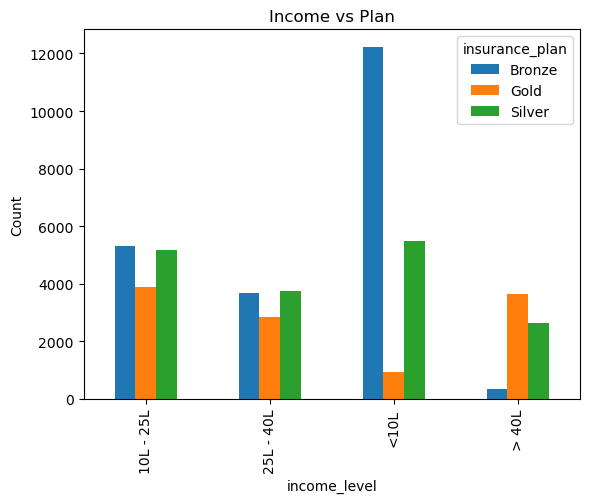

In [26]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.savefig("../outputs/figures/overall/income_vs_plan_bar.png", dpi=300)
plt.show()

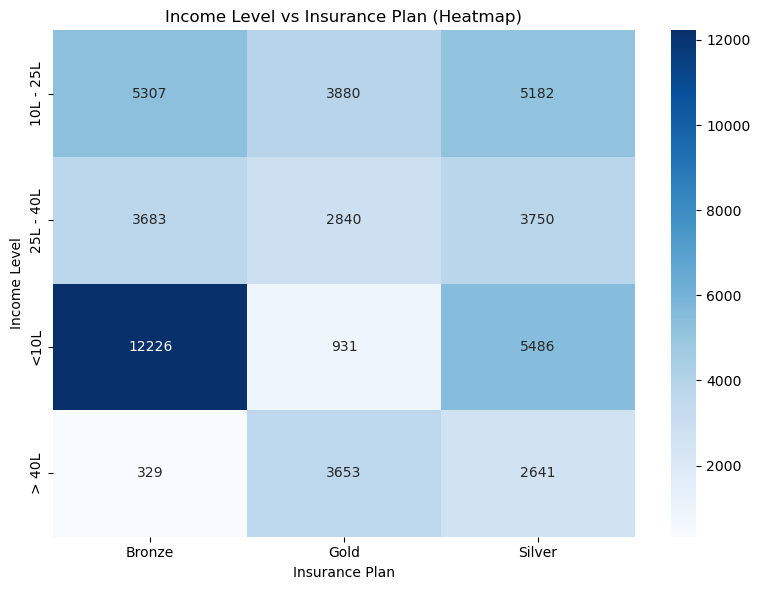

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Income Level vs Insurance Plan (Heatmap)')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.tight_layout()
plt.savefig("../outputs/figures/overall/income_vs_plan_heatmap.png", dpi=300)
plt.show()

### Observations

- **Bronze Plan:** 
  - The **Bronze plan dominates** across all income levels, especially among policyholders earning **below ₹10L** annually (over 12,000 individuals).
  - This reflects a strong preference for affordable coverage among lower-income customers.

- **Silver Plan:**  
  - Maintains a **balanced presence** across all income segments, indicating it serves as a mid-range option for both lower- and middle-income policyholders.
  - Its consistent uptake suggests it may be perceived as offering good value for money.

- **Gold Plan:**  
  - The **Gold plan is most popular among higher-income groups (>₹40L)** — around 3,600 policyholders in that bracket.
  - Uptake is minimal among lower-income customers (<₹10L), confirming that premium plans appeal primarily to high-earning segments.

### Insights

- The distribution clearly demonstrates a **positive association between income level and plan tier** — as income increases, the likelihood of selecting a higher-value plan (Gold) also rises.  
- **Price sensitivity** is evident in lower-income segments, where Bronze dominates.  
- Mid-income brackets (₹10L–₹40L) show **greater diversity in plan selection**, suggesting this group could be a target for upselling or tailored product offerings.

In [28]:
df2.to_parquet("../data/processed/processed.parquet", index=False)
print("Processed data saved to ../data/processed/processed.parquet")

Processed data saved to ../data/processed/processed.parquet


In [29]:
df2.shape

(49908, 13)